In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:

import os
import torch
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from PIL import Image


In [25]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:

# Define dataset path
dataset_path = "/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset"


In [27]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [28]:

# Load the dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Define train/val/test split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensure total sums up correctly

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [29]:

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
# Number of classes
num_classes = len(full_dataset.classes)
print(f"Classes: {full_dataset.classes}, Total Classes: {num_classes}")

# Function to count images per class
def count_images_per_class(dataset):
    class_counts = {cls: 0 for cls in dataset.dataset.classes}
    for _, label in dataset.dataset.samples:
        class_counts[dataset.dataset.classes[label]] += 1
    return class_counts

# Get the count of images per class
class_counts = count_images_per_class(train_dataset)

# Print the count of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Classes: ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa'], Total Classes: 10
Class 'Central Serous Chorioretinopathy-Color Fundus': 606 images
Class 'Diabetic Retinopathy': 3444 images
Class 'Disc Edema': 762 images
Class 'Glaucoma': 2880 images
Class 'Healthy': 2676 images
Class 'Macular Scar': 1937 images
Class 'Myopia': 2251 images
Class 'Pterygium': 102 images
Class 'Retinal Detachment': 750 images
Class 'Retinitis Pigmentosa': 834 images


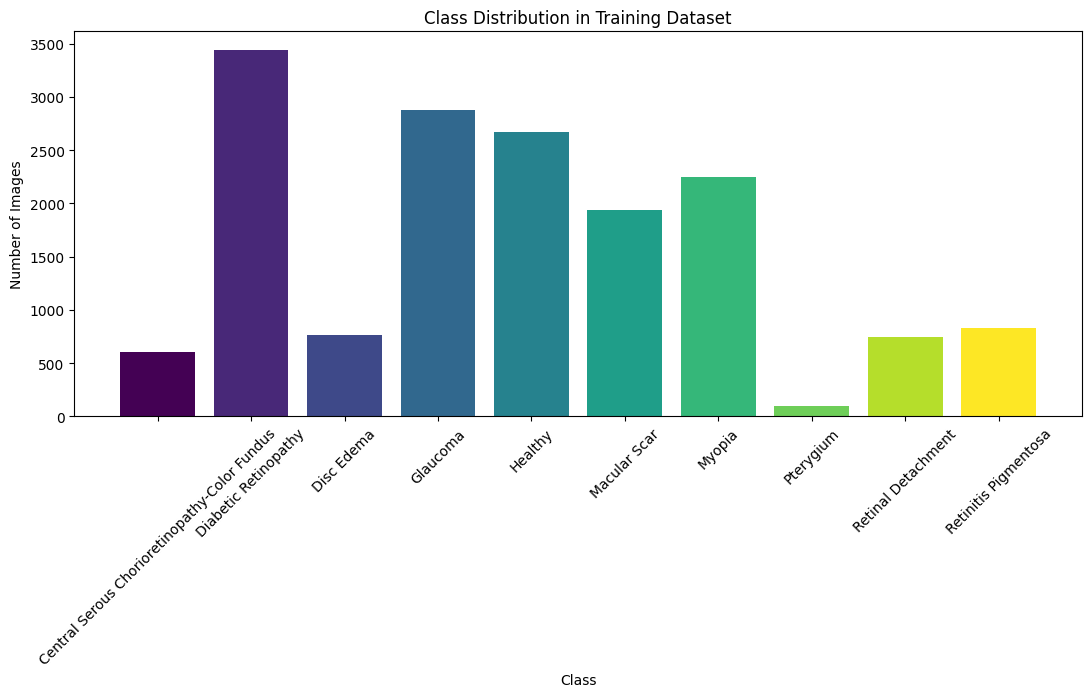

In [31]:

train_class_counts = count_images_per_class(train_dataset)

# Generate a list of colors based on the number of classes
colors = plt.cm.viridis(np.linspace(0, 1, len(train_class_counts)))

# Plot class distribution with different colors
plt.figure(figsize=(13, 5))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color=colors)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

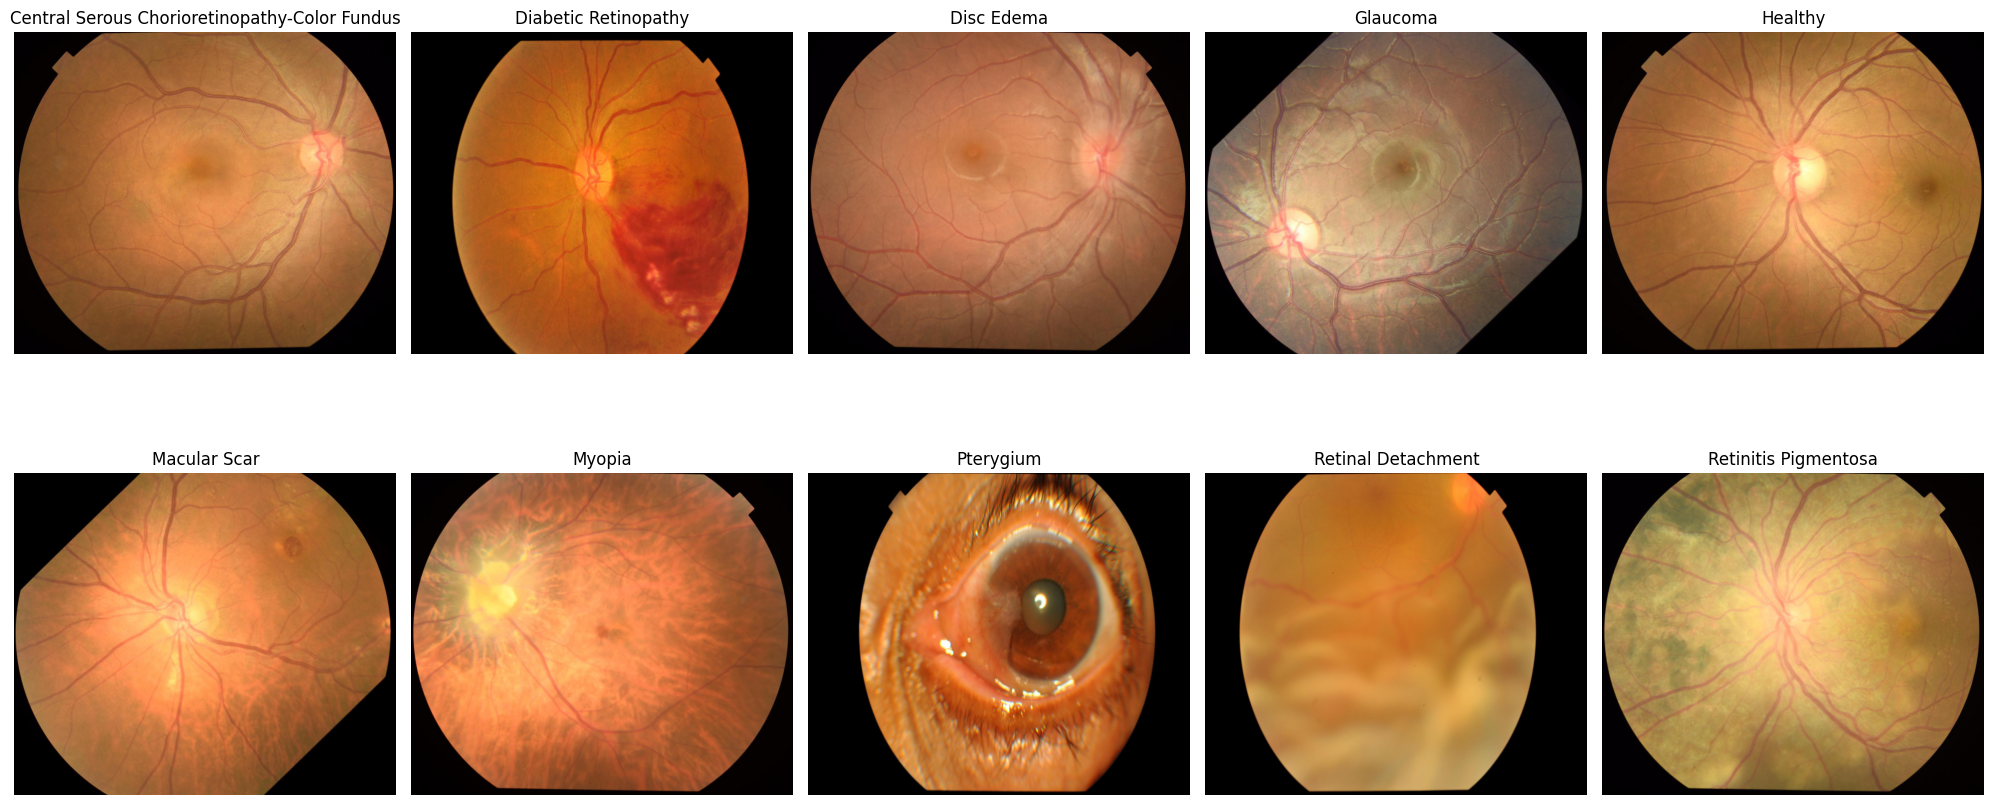

In [35]:


def show_random_images(dataset, num_images=1):
    # Create a grid with 5 images per row
    rows = len(dataset.dataset.classes) // 5 + (len(dataset.dataset.classes) % 5 > 0)
    fig, axes = plt.subplots(rows, 5, figsize=(20, 5 * rows))

    # Flatten axes in case the grid is not fully filled (when the number of classes is not a multiple of 5)
    axes = axes.flatten()

    for idx, cls in enumerate(dataset.dataset.classes):
        # Get the indices for images of the current class
        class_indices = [i for i, (_, label) in enumerate(dataset.dataset.samples) if dataset.dataset.classes[label] == cls]
        
        # Choose a random index for the class
        random_idx = random.choice(class_indices)
        img_path, _ = dataset.dataset.samples[random_idx]

        # Open and display the image
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")
        axes[idx].set_title(cls)

    # Hide any unused axes (in case the number of classes is not divisible by 5)
    for i in range(len(dataset.dataset.classes), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Show one random image per class
show_random_images(train_dataset)

In [36]:


# Function to load pre-trained models with Dropout
def get_model(model_name, num_classes):
    if model_name == "VGG16":
        model = models.vgg16(pretrained=True)
        model.classifier[5] = nn.Dropout(0.5)  # Adding dropout layer
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "MobileNetV3":
        model = models.mobilenet_v3_large(pretrained=True)
        model.classifier[2] = nn.Dropout(0.4)  # Adding dropout layer
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif model_name == "DenseNet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(model.classifier.in_features, num_classes)
        )
    else:
        raise ValueError("Unknown model name")
    
    return model.to(device)

In [37]:


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, save_path="best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = float("inf")
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.save_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("\nEarly stopping triggered!")
                return True
        return False

In [38]:


def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping, epochs=20):
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Check early stopping
        if early_stopping(avg_val_loss, model):
            break

    return train_losses, val_losses

In [ ]:

# Hyperparameter tuning: Trying different optimizers
# models_list = ["VGG16", "MobileNetV3", "DenseNet121"]
models_list = ["MobileNetV3"]
optimizers_list = [optim.Adam, optim.SGD, optim.RMSprop]

best_model = None
best_loss = float("inf")

for model_name in models_list:
    for optimizer_type in optimizers_list:
        print(f"\nTraining {model_name} with {optimizer_type.__name__} optimizer...\n")

        model = get_model(model_name, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_type(model.parameters(), lr=0.001)
        
        # Learning rate scheduler (ReduceLROnPlateau)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

        # Early stopping
        early_stopping = EarlyStopping(patience=5)

        train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping, epochs=20)

        final_val_loss = val_losses[-1]
        if final_val_loss < best_loss:
            best_loss = final_val_loss
            best_model = model_name

print(f"\nBest Model: {best_model} with lowest validation loss: {best_loss:.4f}")


Training MobileNetV3 with Adam optimizer...



In [ ]:

# Load the best model
final_model = get_model(best_model, num_classes)
final_model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on Test Data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate the final model
evaluate_model(final_model, test_loader)